# Chromatin Loop Calling

In [1]:
import os
import importlib
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as ad

from utils.data import DataTree
from utils import out_dire
import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/__init__.py'>

In [1]:
!rm -r ../123ACElog/060625

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
dtree = DataTree("../data")

## Sox2 locus

In [4]:
loader_sox2 = sf.pp.FOF_CT_Loader({
    "between": dtree["huang_ng_2021","between"],
    # "between_rna": dtree["huang_ng_2021","between_rna"]
})
adata_sox2 = loader_sox2.create_adata("chr3")
allele = adata_sox2.obs.index.str.replace(r"^.*_", "", regex=True)
adata_sox2.obs["allele"] = allele

sox2_cast = adata_sox2[adata_sox2.obs["allele"]=="CAST"].copy()
sox2_129 = adata_sox2[adata_sox2.obs["allele"]=="129"].copy()

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


In [12]:
from utils.data import add_noise
noisy_path = {k:os.path.join(out_dire, v.split("/")[-1]) 
              for k, v in loader_sox2.path.items()}
np.random.seed(100)
add_noise(loader_sox2.path, {"X": 1, "Y": 1, "Z": 1}, 
          noisy_path, {"X": 0, "Y": 0, "Z": 50})

loader_sox2n = sf.pp.FOF_CT_Loader(noisy_path)
adata_sox2n = loader_sox2n.create_adata("chr3")
allele = adata_sox2n.obs.index.str.replace(r"^.*_", "", regex=True)
adata_sox2n.obs["allele"] = allele

sox2_castn = adata_sox2n[adata_sox2n.obs["allele"]=="CAST"].copy()
sox2_129n = adata_sox2n[adata_sox2n.obs["allele"]=="129"].copy()

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/load.py:217: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("", np.nan)


In [15]:
sf.pp.axis_weight(sox2_129, False), sf.pp.axis_weight(sox2_129n, False)

(array([0.35015386, 0.35976717, 0.29007897]),
 array([0.35603378, 0.36580852, 0.2781577 ]))

In [9]:
sf.pp.axis_weight(sox2_129, False), sf.pp.axis_weight(sox2_129n, False)

(array([0.35015386, 0.35976717, 0.29007897]),
 array([0.35966285, 0.36953723, 0.27079992]))

In [6]:
sf.pp.axis_weight(sox2_cast, False)

array([0.35346694, 0.36121033, 0.28532273])

## Loop calling on merged data from two replicates

In [141]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 1000, "Y": 1000, "Z": 1000})

In [126]:
n = 800
# err = {"X": 50, "Y": 50, "Z": 100}
err = {"X": 0, "Y": 0, "Z": 200}
np.random.seed(1)

adata = loader.create_adata("chr3")

sub_adata = ad.AnnData(
    obs=np.arange(n, dtype="int64"),
    var=adata.var,
    layers={c: adata[
        adata.obs.sample(n=n, replace=True).index
    ].layers["X"] for c in "XYZ"},
    uns=adata.uns
)
for c in "XYZ":
    e = stats.norm.rvs(size=sub_adata.shape, scale=err[c])
    sub_adata.layers[c] -= np.nanmean(sub_adata.layers[c], axis=1)[:,None]
    sub_adata.layers[c] += e
wts = 1/np.square(np.array(list(err.values())) + 50)
print(wts/np.sum(wts))
sf.pp.axis_weight(sub_adata, False)

[0.49019608 0.49019608 0.01960784]
Axis X sd: 197.890
Axis Y sd: 204.470
Axis Z sd: 279.707


array([0.41030496, 0.38432098, 0.20537406])

In [94]:
sf.pp.axis_weight(adata, False)

Axis X sd: 199.680
Axis Y sd: 189.854
Axis Z sd: 176.394


array([0.29519056, 0.32653649, 0.37827296])

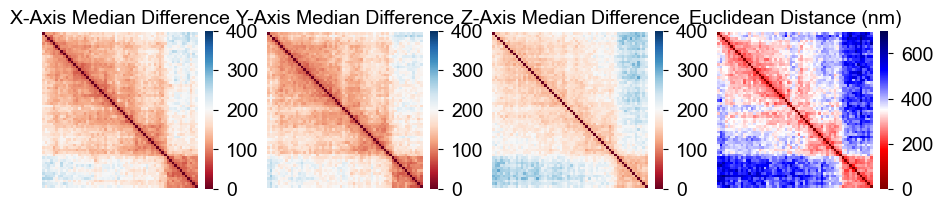

In [124]:
from utils.maps import dist_diff_heatmaps
fig, axes = plt.subplots(1, 4, figsize=(9, 2))
dist_diff_heatmaps(axes, sub_adata, 400, 700)

In [145]:
res_sf1_path = os.path.join(out_dire, "loop_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    loop = sf.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=sf.tl.TwoSampleT)
    sf.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "loop_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    loop = sf.tl.LoopCaller(gap=50e3, ltclass=sf.tl.AxisWiseF)
    sf.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

Axis X sd: 232.734
Axis Y sd: 239.638
Axis Z sd: 171.426
Axis X sd: 206.811
Axis Y sd: 202.704
Axis Z sd: 167.466
Axis X sd: 199.680
Axis Y sd: 189.854
Axis Z sd: 176.394
Axis X sd: 187.872
Axis Y sd: 189.248
Axis Z sd: 156.759
Axis X sd: 188.736
Axis Y sd: 185.700
Axis Z sd: 156.595
Axis X sd: 160.520
Axis Y sd: 165.615
Axis Z sd: 157.883
Axis X sd: 304.107
Axis Y sd: 311.162
Axis Z sd: 217.447
Axis X sd: 237.213
Axis Y sd: 219.640
Axis Z sd: 174.115
Axis X sd: 234.353
Axis Y sd: 215.638
Axis Z sd: 170.578
Axis X sd: 242.251
Axis Y sd: 239.548
Axis Z sd: 181.125
Axis X sd: 264.592
Axis Y sd: 290.517
Axis Z sd: 190.255
Axis X sd: 218.815
Axis Y sd: 201.394
Axis Z sd: 162.386
Axis X sd: 223.576
Axis Y sd: 221.900
Axis Z sd: 225.329
Axis X sd: 200.694
Axis Y sd: 194.273
Axis Z sd: 183.010
Axis X sd: 181.676
Axis Y sd: 194.767
Axis Z sd: 168.031
Axis X sd: 226.946
Axis Y sd: 201.034
Axis Z sd: 175.235
Axis X sd: 196.628
Axis Y sd: 191.468
Axis Z sd: 157.640
Axis X sd: 174.799
Axis Y sd: 1

In [6]:
res_sf1[res_sf1["candidate"]].groupby("c1").count()

,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit,final
c1,,,,,,,,,,,,
chr1,87,87,87,87,87,87,87,87,87,87,87,87
chr10,19,19,19,19,19,19,19,19,19,19,19,19
chr12,3,3,3,3,3,3,3,3,3,3,3,3
chr13,103,103,103,103,103,103,103,103,103,103,103,103
chr14,21,21,21,21,21,21,21,21,21,21,21,21
chr15,7,7,7,7,7,7,7,7,7,7,7,7
chr16,15,15,15,15,15,15,15,15,15,15,15,15
chr19,2,2,2,2,2,2,2,2,2,2,2,2
chr2,24,24,24,24,24,24,24,24,24,24,24,24


In [6]:
noised_path = {
    "rep1": os.path.join(out_dire, "takei_nature_25kb_rep1.csv"),
    "rep2": os.path.join(out_dire, "takei_nature_25kb_rep2.csv")
}
from utils.data import add_noise
noise = {"X": 100, "Y": 100, "Z": 0}
ratio = {"X": 1000, "Y": 1000, "Z": 1000}
np.random.seed(0)
add_noise(loader.path, ratio, noised_path, noise)
noised_loader = sf.pp.FOF_CT_Loader(noised_path, voxel_ratio=ratio)

In [8]:
res_sf1_noised_path = os.path.join(out_dire, "loop_result_sf1_noised.csv")
if not os.path.exists(res_sf1_noised_path):
    loop = sf.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=sf.tl.TwoSampleT)
    sf.wr.caller_wrapper(noised_loader, loop=loop, loop_path=res_sf1_noised_path)
res_sf1_noised = pd.read_csv(res_sf1_noised_path, sep="\t")
res_sf2_noised_path = os.path.join(out_dire, "loop_result_sf2_noised.csv")
if not os.path.exists(res_sf2_noised_path):
    loop = sf.tl.LoopCaller(gap=50e3, ltclass=sf.tl.AxisWiseF)
    sf.wr.caller_wrapper(noised_loader, loop=loop, loop_path=res_sf2_noised_path)
res_sf2_noised = pd.read_csv(res_sf2_noised_path, sep="\t")

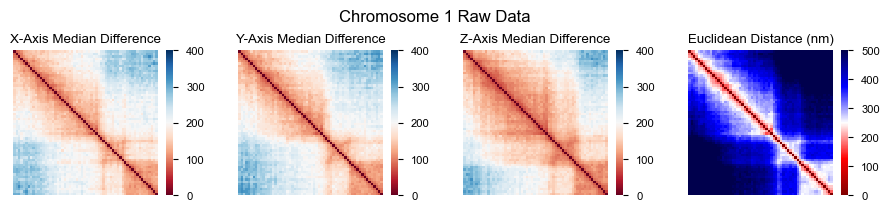

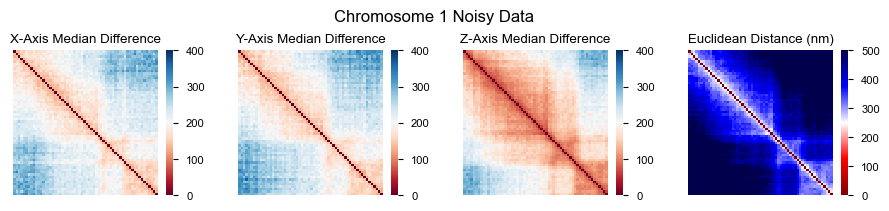

In [9]:
from utils.maps import dist_diff_heatmaps
chr_id = "chr1"
adata_raw = loader.create_adata(chr_id)
fig, axes = plt.subplots(1, 4, figsize=(9, 2))
dist_diff_heatmaps(axes, adata_raw, 400, 500)
fig.suptitle(f"Chromosome {chr_id[3:]} Raw Data")
fig.savefig(os.path.join(out_dire, "s4a_median_hm_raw.pdf"), bbox_inches="tight")

adata_noised = noised_loader.create_adata(chr_id)
fig, axes = plt.subplots(1, 4, figsize=(9, 2))
dist_diff_heatmaps(axes, adata_noised, 400, 500)
fig.suptitle(f"Chromosome {chr_id[3:]} Noisy Data")
fig.savefig(os.path.join(out_dire, "s4b_median_hm_noi.pdf"), bbox_inches="tight")

In [167]:
np.random.seed(0)
adata = loader.create_adata("chr2")
err = {"X": 0, "Y": 0, "Z": 100}
adatan = adata.copy()
for c in "XYZ":
    e = stats.norm.rvs(size=adatan.shape, scale=err[c])
    adatan.layers[c] -= np.nanmean(adatan.layers[c], axis=1)[:,None]
    adatan.layers[c] += e
loop = sf.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=sf.tl.TwoSampleT)
res1, res11 = loop.call_loops(adata), loop.call_loops(adatan)
loop = sf.tl.LoopCaller(gap=50e3)
res2, res21 = loop.call_loops(adata), loop.call_loops(adatan)

Axis X sd: 206.811
Axis Y sd: 202.704
Axis Z sd: 167.466
Axis X sd: 206.811
Axis Y sd: 202.704
Axis Z sd: 193.201


In [135]:
sf.settings.fontsize = 10

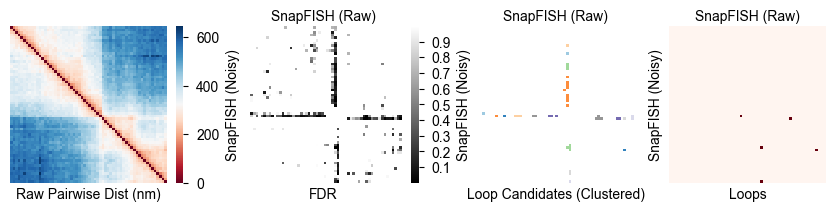

In [168]:
fig, axes = plt.subplots(1, 4, figsize=(8.5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adata, False), 
                       sf.pp.median_pdist(adatan, False), ax=axes[0])
axes[0].set_title("Raw Pairwise Dist (nm)", y=-0.15)
sf.pl.pairwise_heatmap(res1["fdr"], res11["fdr"], x="SnapFISH (Raw)", 
                       y="SnapFISH (Noisy)", ax=axes[1], cmap="gray", 
                       cbar_kws={'ticks': np.linspace(0, 1, 11)})
axes[1].set_title("FDR", y=-0.15)
sf.pl.pairwise_heatmap(res1["label"], res11["label"], x="SnapFISH (Raw)", 
                       y="SnapFISH (Noisy)", ax=axes[2], cmap="tab20c", cbar=False)
axes[2].set_title("Loop Candidates (Clustered)", y=-0.15)
sf.pl.pairwise_heatmap(res1["summit"], res11["summit"], x="SnapFISH (Raw)", 
                       y="SnapFISH (Noisy)", ax=axes[3], cmap="Reds", cbar=False)
axes[3].set_title("Loops", y=-0.15)
fig.savefig(os.path.join(out_dire, "loop_calling_raw.pdf"), bbox_inches="tight")

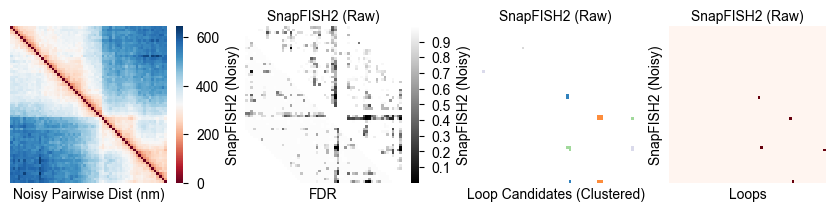

In [169]:
fig, axes = plt.subplots(1, 4, figsize=(8.5, 2))
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adata, False), 
                       sf.pp.median_pdist(adatan, False), ax=axes[0])
axes[0].set_title("Noisy Pairwise Dist (nm)", y=-0.15)
sf.pl.pairwise_heatmap(res2["fdr"], res21["fdr"], x="SnapFISH2 (Raw)", 
                       y="SnapFISH2 (Noisy)", ax=axes[1], cmap="gray", 
                       cbar_kws={'ticks': np.linspace(0, 1, 11)})
axes[1].set_title("FDR", y=-0.15)
sf.pl.pairwise_heatmap(res2["label"], res21["label"], x="SnapFISH2 (Raw)", 
                       y="SnapFISH2 (Noisy)", ax=axes[2], cmap="tab20c", cbar=False)
axes[2].set_title("Loop Candidates (Clustered)", y=-0.15)
loops1 = np.where(res2["pval"] < 1e-5, res2["summit"], 0)
loops2 = np.where(res21["pval"] < 1e-5, res21["summit"], 0)
sf.pl.pairwise_heatmap(loops1, loops2, x="SnapFISH2 (Raw)", 
                       y="SnapFISH2 (Noisy)", ax=axes[3], cmap="Reds", cbar=False)
axes[3].set_title("Loops", y=-0.15)
fig.savefig(os.path.join(out_dire, "loop_calling_noi.pdf"), bbox_inches="tight")

## Using the noise-free as the ground truth

In [12]:
print("SnapFISH", res_sf1.final.sum(), res_sf1_noised.final.sum(), end="\t")
print("SnapFISH2", res_sf2.final.sum(), res_sf2_noised.final.sum(), end="\t")

SnapFISH 45 47	SnapFISH2 34 27	

## PLAC-seq

In [5]:
from utils.utils import filter_loops
plac_ctcf_path = "../data/MAPS/mESC_CTCF_combine_MAPS_call.bedpe"
plac_ctcf = pd.read_csv(plac_ctcf_path, sep="\t")
# Keep cluster summits and singletons
plac_ctcf = plac_ctcf[(plac_ctcf.summit==1)|(plac_ctcf.type=="Singleton")]
plac_ctcf = filter_loops(plac_ctcf, loader)
plac_ctcf.shape

(158, 7)

In [6]:
plac_h3k4me3_path = "../data/MAPS/mESC_H3K4me3_combine_MAPS_call.bedpe"
plac_h3k4me3 = pd.read_csv(plac_h3k4me3_path, sep="\t")
# Keep cluster summits and singletons
plac_h3k4me3 = plac_h3k4me3[(plac_h3k4me3.summit==1)|(plac_h3k4me3.type=="Singleton")]
plac_h3k4me3 = filter_loops(plac_h3k4me3, loader)
plac_h3k4me3.shape

(238, 7)

In [7]:
ctcf_pet_path = dtree["chiapet_mesc", "CTCF", "129S1/SvImJ"]
ctcf_pet = pd.read_csv(ctcf_pet_path, sep="\t", header=None)
ctcf_pet.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "count"]
ctcf_pet = ctcf_pet[ctcf_pet["count"] > 5]
ctcf_pet = filter_loops(ctcf_pet, loader)
ctcf_pet.shape

(243, 7)

In [8]:
polr2a_pet_path = dtree["chiapet_mesc", "POLR2A", "129S1/SvImJ"]
polr2a_pet = pd.read_csv(polr2a_pet_path, sep="\t", header=None)
polr2a_pet.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "count"]
polr2a_pet = polr2a_pet[polr2a_pet["count"] > 5]
polr2a_pet = filter_loops(polr2a_pet, loader)
polr2a_pet.shape

(297, 7)

In [9]:
hicexpl_path = "../data/bonev_cell_2017/hicexplorer.bedgraph"
edf = pd.read_csv(hicexpl_path, sep="\t", header=None)
edf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "pval"]
edf["c1"] = "chr" + edf["c1"].astype(str)
edf["c2"] = "chr" + edf["c2"].astype(str)
edf = filter_loops(edf, loader)
edf.shape

(55, 7)

In [10]:
fithic2_path = "../data/bonev_cell_2017/output/" \
    + "merged.spline_pass1.res10000.significances.fdr.0.01.bedpe"
fdf = pd.read_csv(fithic2_path, sep="\t", header=None)
fdf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "CC", "pval", "fdr"]
fdf = filter_loops(fdf, loader)
fdf.shape

(213, 7)

In [12]:
loop_dfs = {
    "plac_ctcf": plac_ctcf, "plac_h3k4me3": plac_h3k4me3, "ctcf_pet": ctcf_pet, 
    "polr2a_pet": polr2a_pet, "hicexpl": edf, "fithic2": fdf
}
common_loops = sf.tl.all_possible_pairs(loader)
for k, v in loop_dfs.items():
    common_loops[k] = sf.tl.loop_overlap(common_loops, v, -1)["overlapped"]
common_loops["count"] = (common_loops.iloc[:,-6:]==3).sum(axis=1)
common_loops = common_loops[common_loops["count"] > 1]
common_loops.to_csv(os.path.join(out_dire, "common_loops.bedpe"), sep="\t", index=False)

run `AxisWiseTest/scripts/err_rep`

`scp "hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/060625/*.tsv" .`

In [37]:
rep_call_all = pd.read_csv(os.path.join(out_dire, "loop_err_rep_all.tsv"), sep="\t")
rep_call_all = rep_call_all[rep_call_all.final]
grp_obj = rep_call_all.groupby(["method", "err", "rep"], sort=False)
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]

rows = []
for (m, e, r), df in grp_obj:
    # tp = pd.merge(df, common_loops, on=cols, how="inner")
    tp = sf.tl.loop_overlap(df, common_loops)
    tp = tp[tp["overlapped"]==3]
    pr = len(tp)/len(df)
    rc = len(tp)/len(common_loops)
    rows.append([m, e, r, len(df), len(tp), pr, rc])
rows = pd.DataFrame(rows, columns=["method", "err", "rep", "total", "tp", "precision", "recall"])

In [95]:
c1, c2 = sns.palettes.color_palette("dark")[:2]

In [116]:
sf.settings.fontsize = 14

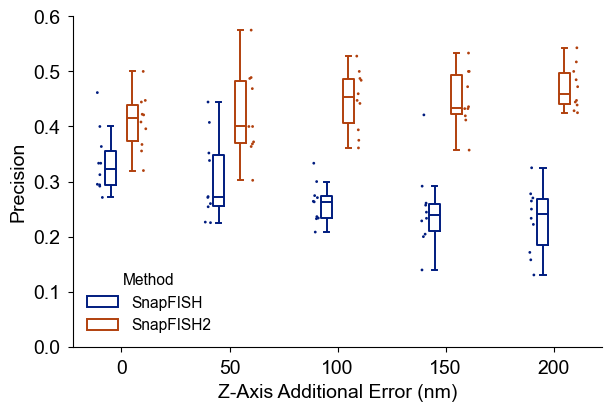

In [120]:
fig, ax = plt.subplots(figsize=(6, 4))
palette = {"SnapFISH": c1, "SnapFISH2": c2}
sns.boxplot(rows, x="err", y="precision", hue="method", native_scale=True, 
            fliersize=0, fill=False, width=.4, gap=1.5, palette=palette, ax=ax)
sns.stripplot(rows, x="err", y="precision", hue="method", native_scale=True, 
              dodge=True, s=2, linewidth=0, jitter=.05, palette=palette, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Method", loc="lower left")
ax.set(xlabel="Z-Axis Additional Error (nm)", ylabel="Precision", ylim=(0, 0.6))
ax.grid(False)
fig.savefig(os.path.join(out_dire, "loop_precision_by_err.png"), dpi=800, bbox_inches="tight")

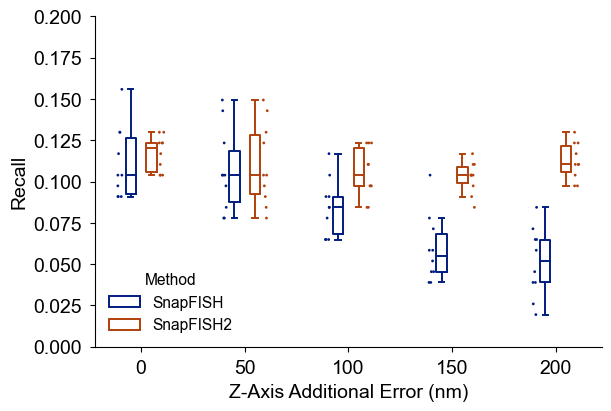

In [121]:
fig, ax = plt.subplots(figsize=(6, 4))
palette = {"SnapFISH": c1, "SnapFISH2": c2}
sns.boxplot(rows, x="err", y="recall", hue="method", native_scale=True, 
            fliersize=0, fill=False, width=.4, gap=1.5, palette=palette, ax=ax)
sns.stripplot(rows, x="err", y="recall", hue="method", native_scale=True, 
              dodge=True, s=2, linewidth=0, jitter=.05, palette=palette, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Method", loc="lower left")
ax.set(xlabel="Z-Axis Additional Error (nm)", ylabel="Recall", ylim=(0, 0.2))
ax.grid(False)
fig.savefig(os.path.join(out_dire, "loop_recall_by_err.png"), dpi=800, bbox_inches="tight")

In [176]:
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
res_sf1_final, res_sf2_final = res_sf1[res_sf1.final], res_sf2[res_sf2.final]
shared = pd.merge(res_sf2_final, res_sf1_final[cols], how="inner", on=cols)
res_sf2_specific = pd.concat([res_sf2_final, shared]).drop_duplicates(cols, keep=False)

overlapped = sf.tl.loop_overlap(res_sf2_final, common_loops, -1)
overlapped = overlapped[overlapped["overlapped"]==3]
len(overlapped)/len(res_sf2_final)

0.4117647058823529

S7 reference loop counts

In [55]:
loop_dfs = {
    "plac_ctcf": plac_ctcf, "plac_h3k4me3": plac_h3k4me3, "ctcf_pet": ctcf_pet, 
    "polr2a_pet": polr2a_pet, "hicexpl": edf, "fithic2": fdf
}
test_dfs = []
for df in [res_sf1, res_sf2, res_sf1_noised, res_sf2_noised]:
    test_df = df[df.final].copy()
    # test_df = df.copy()
    print(len(test_df), end="\t")
    for k, v in loop_dfs.items():
        test_df[k] = sf.tl.loop_overlap(test_df, v, -1)["overlapped"]
    test_df["count"] = (test_df.iloc[:, -6:] == 3).sum(axis=1)
    test_dfs.append(test_df)

45	34	52	33	

In [56]:
test_df.groupby("c1", sort=False)["count"].mean()

c1
chr1     0.000000
chr2     3.000000
chr3     0.833333
chr4     3.000000
chr6     3.666667
chr8     0.500000
chr12    0.000000
chr13    1.181818
chr14    5.000000
chr15    0.000000
chr16    4.000000
Name: count, dtype: float64

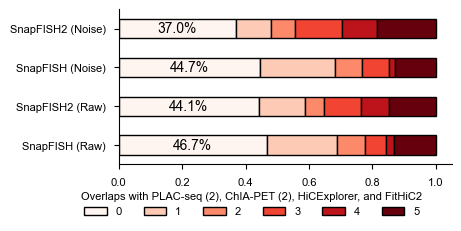

In [28]:
loop_count = pd.concat([
    test_df["count"].value_counts() for test_df in test_dfs
], axis=1).fillna(0).astype(int)
loop_count.columns = ["SnapFISH (Raw)", "SnapFISH2 (Raw)",
                      "SnapFISH (Noise)", "SnapFISH2 (Noise)"]
loop_frac = loop_count / loop_count.sum(axis=0)
loop_frac = loop_frac.loc[np.arange(len(loop_frac), dtype=int)]
fig, ax = plt.subplots(figsize=(4.5, 2.2))
loop_frac.T.plot(kind="barh", stacked=True, linewidth=1, edgecolor="k", ax=ax, colormap="Reds")
for i in range(4):
    bar = ax.patches[i]
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
            f"{bar.get_width()*100:.1f}%", ha="center", verticalalignment="center")
ax.legend(loc="lower center", ncol=7, bbox_to_anchor=(0.4, -0.4), 
          title="Overlaps with PLAC-seq (2), ChIA-PET (2), HiCExplorer, and FitHiC2")
ax.grid(False)
fig.savefig(os.path.join(out_dire, "overlap_6count.pdf"), bbox_inches="tight")

In [29]:
loop_frac.iloc[:2,].sum(axis=0)

SnapFISH (Raw)       0.688889
SnapFISH2 (Raw)      0.588235
SnapFISH (Noise)     0.680851
SnapFISH2 (Noise)    0.481481
dtype: float64

In [30]:
common_loops = sf.tl.all_possible_pairs(loader)
for k, v in loop_dfs.items():
    common_loops[k] = sf.tl.loop_overlap(common_loops, v, -1)["overlapped"]
common_loops["count"] = (common_loops.iloc[:,-6:]==3).sum(axis=1)
common_loops = common_loops[common_loops["count"] > 1]
common_loops.to_csv(os.path.join(out_dire, "common_loops.bedpe"), sep="\t", index=False)

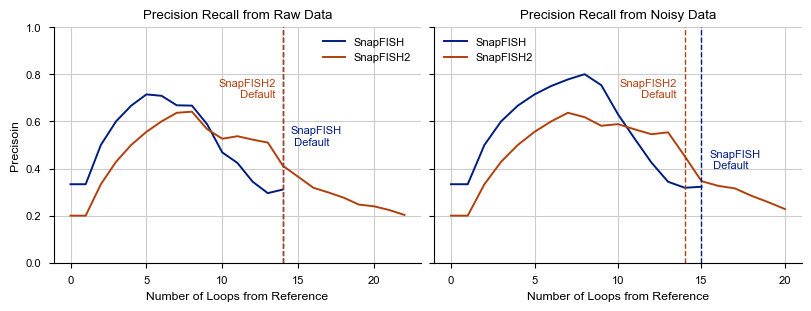

In [31]:
from utils.utils import precision_recall_res
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df1 = precision_recall_res(res_sf1, common_loops)
df1["Method"] = "SnapFISH"
df2 = precision_recall_res(res_sf2, common_loops)
df2["Method"] = "SnapFISH2"
sns.lineplot(pd.concat([df1, df2]), x="# True Loops", y="Precisoin", hue="Method", 
             palette={"SnapFISH": c1, "SnapFISH2": c2}, errorbar=None, ax=axes[0])
v1 = len(pd.merge(res_sf1[res_sf1.final], common_loops, how="inner", 
                  on=["c1", "s1", "e1", "c2", "s2", "e2"]))
axes[0].axvline(v1, color=c1, linestyle="--", linewidth=1)
axes[0].text(v1+0.5, 0.5, f"SnapFISH\n Default", ha="left", color=c1, fontsize=sf.settings.fontsize*.8)
v2 = len(pd.merge(res_sf2[res_sf2.final], common_loops, how="inner", 
                  on=["c1", "s1", "e1", "c2", "s2", "e2"]))
axes[0].axvline(v2, color=c2, linestyle="--", linewidth=1)
axes[0].text(v2-0.5, 0.7, f"SnapFISH2\n Default", ha="right", color=c2, fontsize=sf.settings.fontsize*.8)
axes[0].set(title="Precision Recall from Raw Data")

df1n = precision_recall_res(res_sf1_noised, common_loops)
df1n["Method"] = "SnapFISH"
df2n = precision_recall_res(res_sf2_noised, common_loops)
df2n["Method"] = "SnapFISH2"
sns.lineplot(pd.concat([df1n, df2n]), x="# True Loops", y="Precisoin", hue="Method", 
             palette={"SnapFISH": c1, "SnapFISH2": c2}, errorbar=None, ax=axes[1])
v1 = len(pd.merge(res_sf1_noised[res_sf1_noised.final], common_loops, how="inner", 
                  on=["c1", "s1", "e1", "c2", "s2", "e2"]))
axes[1].axvline(v1, color=c1, linestyle="--", linewidth=1)
axes[1].text(v1+0.5, 0.4, f"SnapFISH\n Default", ha="left", color=c1, fontsize=sf.settings.fontsize*.8)
v2 = len(pd.merge(res_sf2_noised[res_sf2_noised.final], common_loops, how="inner", 
                  on=["c1", "s1", "e1", "c2", "s2", "e2"]))
axes[1].axvline(v2, color=c2, linestyle="--", linewidth=1)
axes[1].text(v2-0.5, 0.7, f"SnapFISH2\n Default", ha="right", color=c2, fontsize=sf.settings.fontsize*.8)
axes[1].set(title="Precision Recall from Noisy Data")
for ax in axes:
    ax.set(xticks=[0, 5, 10, 15, 20], xticklabels=[0, 5, 10, 15, 20])
    ax.set(ylim=(0, 1), xlabel="Number of Loops from Reference")
    ax.legend(loc="best")
fig.savefig(os.path.join(out_dire, "loop_precision_recall.pdf"), bbox_inches="tight")

In [301]:
df1[df1["# True Loops"]==17]

,Precisoin,# True Loops,Method
0,0.269841,17,SnapFISH


In [302]:
df2[df2["# True Loops"]==17]

,Precisoin,# True Loops,Method
52,0.333333,17,SnapFISH2
53,0.340000,17,SnapFISH2
54,0.346939,17,SnapFISH2
55,0.354167,17,SnapFISH2
56,0.361702,17,SnapFISH2
57,0.369565,17,SnapFISH2


/opt/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: cannot reindex on an axis with duplicate labels

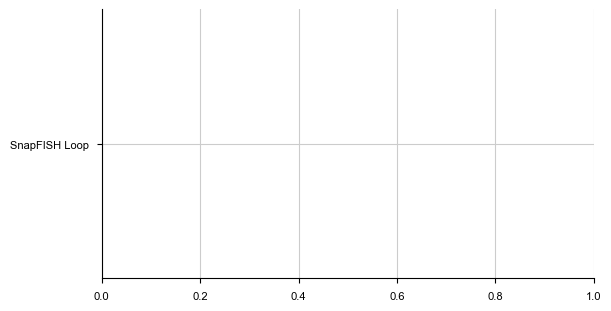

In [32]:
loop_pval1 = pd.merge(common_loops, res_sf1, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval1["type"] = "SnapFISH Loop"
null_pval1 = res_sf1.drop(loop_pval1.index)
null_pval1 = null_pval1[null_pval1.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval1["type"] = "SnapFISH Null"
loop_pval2 = pd.merge(common_loops, res_sf2, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval2["type"] = "SnapFISH2 Loop"
null_pval2 = res_sf2.drop(loop_pval2.index)
null_pval2 = null_pval2[null_pval2.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval2["type"] = "SnapFISH2 Null"

plt_df = pd.concat([loop_pval1, null_pval1, loop_pval2, null_pval2])
plt_df["log10pval"] = np.log10(plt_df["pval"])
plt_df = plt_df[["log10pval", "type"]].dropna()
fig, ax = plt.subplots(figsize=(6, 3))
order = ["SnapFISH Loop", "SnapFISH2 Loop", "SnapFISH Null", "SnapFISH2 Null"]
palette = {order[0]: c1, order[1]: c2, order[2]: c1, order[3]: c2}
sns.boxplot(plt_df[["log10pval", "type"]], x="log10pval", y="type", 
            palette=palette, showfliers=False, width=.4, orient="h", 
            order=order, hue="type", legend=False, ax=ax)
ax.grid(False)

yticks = []
for ticklabel in ax.get_yticklabels():
    for i, o in enumerate(order):
        if ticklabel.get_text() == o:
            yticks.append(i)
yticks = np.array(yticks)

for (i, j), t in zip([(0, 1), (2, 3)], [">", "<"]):
        y1, y2 = yticks[i], yticks[j]
        xmax = max(
            plt_df.loc[plt_df["type"] == order[i], "log10pval"].max(),
            plt_df.loc[plt_df["type"] == order[j], "log10pval"].max()
        ) + 0.3
        ax.plot([xmax-.1, xmax, xmax, xmax-.1], [y1, y1, y2, y2], color="k", lw=1)
        ax.text(xmax + 0.05, (y1 + y2) / 2, "***", va="center", ha="left", 
                rotation=90, fontsize=14)
        ax.text(
            xmax + 0.5, (y1 + y2) / 2, 
            fr"$H_1: p_{{\text{{SnapFISH}}}} {{{t}}} p_{{\text{{SnapFISH2}}}}$", 
            va="center", ha="left"
        )
ax.set(xlim=(-6.5, 5), xlabel="log 10 P-value", ylabel=None)

fig.savefig(os.path.join(out_dire, "loop_pval.pdf"), bbox_inches="tight")

In [390]:
pvals = np.vstack([null_pval1.pval.values, null_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="less")

WilcoxonResult(statistic=141505515.0, pvalue=5.769059219277065e-27)

In [391]:
pvals = np.vstack([loop_pval1.pval.values, loop_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="greater")

WilcoxonResult(statistic=8135.0, pvalue=4.617813449658001e-05)

same plot for data with noise
compare noise and raw p-values

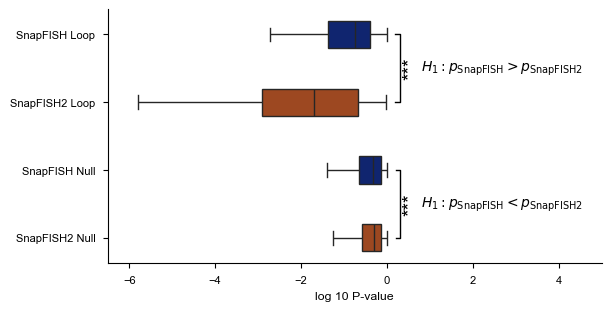

In [404]:
loop_pval1 = pd.merge(common_loops, res_sf1_noised, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval1["type"] = "SnapFISH Loop"
null_pval1 = res_sf1_noised.drop(loop_pval1.index)
null_pval1 = null_pval1[null_pval1.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval1["type"] = "SnapFISH Null"
loop_pval2 = pd.merge(common_loops, res_sf2_noised, how="left", 
                      on=["c1", "s1", "e1", "c2", "s2", "e2"])
loop_pval2["type"] = "SnapFISH2 Loop"
null_pval2 = res_sf2_noised.drop(loop_pval2.index)
null_pval2 = null_pval2[null_pval2.c1.isin([f"chr{n}" for n in range(1, 20)])]
null_pval2["type"] = "SnapFISH2 Null"

plt_df = pd.concat([loop_pval1, null_pval1, loop_pval2, null_pval2])
plt_df["log10pval"] = np.log10(plt_df["pval"])
plt_df = plt_df[["log10pval", "type"]].dropna()
fig, ax = plt.subplots(figsize=(6, 3))
order = ["SnapFISH Loop", "SnapFISH2 Loop", "SnapFISH Null", "SnapFISH2 Null"]
palette = {order[0]: c1, order[1]: c2, order[2]: c1, order[3]: c2}
sns.boxplot(plt_df[["log10pval", "type"]], x="log10pval", y="type", 
            palette=palette, showfliers=False, width=.4, orient="h", 
            order=order, hue="type", legend=False, ax=ax)
ax.grid(False)

yticks = []
for ticklabel in ax.get_yticklabels():
    for i, o in enumerate(order):
        if ticklabel.get_text() == o:
            yticks.append(i)
yticks = np.array(yticks)

for (i, j), t in zip([(0, 1), (2, 3)], [">", "<"]):
        y1, y2 = yticks[i], yticks[j]
        xmax = max(
            plt_df.loc[plt_df["type"] == order[i], "log10pval"].max(),
            plt_df.loc[plt_df["type"] == order[j], "log10pval"].max()
        ) + 0.3
        ax.plot([xmax-.1, xmax, xmax, xmax-.1], [y1, y1, y2, y2], color="k", lw=1)
        ax.text(xmax + 0.05, (y1 + y2) / 2, "***", va="center", ha="left", 
                rotation=90, fontsize=14)
        ax.text(
            xmax + 0.5, (y1 + y2) / 2, 
            fr"$H_1: p_{{\text{{SnapFISH}}}} {{{t}}} p_{{\text{{SnapFISH2}}}}$", 
            va="center", ha="left"
        )
ax.set(xlim=(-6.5, 5), xlabel="log 10 P-value", ylabel=None)

fig.savefig(os.path.join(out_dire, "loop_pval_noise.pdf"), bbox_inches="tight")

In [405]:
pvals = np.vstack([null_pval1.pval.values, null_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="less")

WilcoxonResult(statistic=140295681.0, pvalue=3.041463057596474e-32)

In [406]:
pvals = np.vstack([loop_pval1.pval.values, loop_pval2.pval.values])
pvals = pvals[:,~np.isnan(pvals).any(axis=0)]
stats.wilcoxon(pvals[0], pvals[1], alternative="greater")

WilcoxonResult(statistic=8907.0, pvalue=5.714064347676805e-08)

In [388]:
np.mean((pvals[0] - pvals[1])>0)

0.4725203776934872

In [217]:
stats.wilcoxon(res_sf1.pval, res_sf2.pval, alternative="greater")

WilcoxonResult(statistic=nan, pvalue=nan)

In [213]:
stats.wilcoxon(loop_pval1.pval, loop_pval2.pval, alternative="greater")

WilcoxonResult(statistic=8135.0, pvalue=4.617813449658001e-05)

In [239]:
len(common_loops)

154

In [125]:
loop_dfs_ls = list(loop_dfs.values())
common_loops = loop_dfs_ls[0]
for df in loop_dfs_ls[1:]:
    common_loops = pd.merge(
        common_loops.iloc[:,:6], df.iloc[:,:6], how="outer", 
        on=["c1", "s1", "e1", "c2", "s2", "e2"]
    )
len(common_loops)

946

In [89]:
res_sf2[res_sf2.final].shape

(30, 13)

In [140]:
loop_dfs_ls = [plac_ctcf, ctcf_pet, edf, fdf, res_sf2[res_sf2.final]]
common_loops = loop_dfs_ls[0]
for df in loop_dfs_ls[1:]:
    common_loops = pd.merge(
        common_loops.iloc[:,:6], df.iloc[:,:6], how="inner", 
        on=["c1", "s1", "e1", "c2", "s2", "e2"]
    )
common_loops

,c1,s1,e1,c2,s2,e2
0,chr2,109900000,109925000,chr2,110200000,110225000
1,chr2,110225000,110250000,chr2,110550000,110575000
2,chr3,8950000,8975000,chr3,9050000,9075000
3,chr6,50300000,50325000,chr6,50525000,50550000
4,chr6,50675000,50700000,chr6,50800000,50825000
5,chr14,66375000,66400000,chr14,66775000,66800000


## ChIA-PET

In [17]:
fish_path = dtree["takei_nature_2021", "25Kb", "rep1"]
ctcf_path = dtree["chiapet_mesc", "CTCF", "129S1/SvImJ"]
polr2a_path = dtree["chiapet_mesc", "POLR2A", "129S1/SvImJ"]

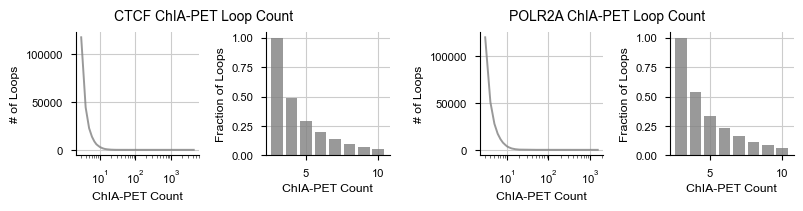

In [18]:
from utils.lines import chiapet_count_pl
fig = plt.figure(figsize=(8, 2))
sfig = fig.subfigures(1, 2)
chiapet_count_pl(ctcf_path, sfig[0])
sfig[0].suptitle("CTCF ChIA-PET Loop Count", fontsize=sf.settings.fontsize)
chiapet_count_pl(polr2a_path, sfig[1])
sfig[1].suptitle("POLR2A ChIA-PET Loop Count", fontsize=sf.settings.fontsize)
fig.savefig(os.path.join(out_dire, "s5a_chiapetcount.pdf"), bbox_inches="tight")

In [19]:
from utils.data import filter_chiapet
pet_paths = {"CTCF":{}, "POLR2A":{}}
for target in pet_paths:
    for min_count in [0, 5, 10]:
        fname = f"{target}_129S1SvImJ_25kb_min{min_count}.bedpe"
        pet_paths[target][min_count] = os.path.join(out_dire, fname)
        filter_chiapet(
            fish_path=fish_path, 
            chiapet_path=dtree["chiapet_mesc", target, "129S1/SvImJ"],
            out_path=pet_paths[target][min_count], min_count=min_count
        )

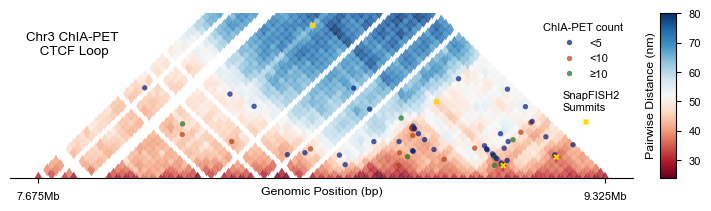

In [20]:
from utils.utils import chiapet_sub_df
chr_id, cut_lo, cut_hi = "chr3", 1e5, 1e6
adata = loader.create_adata(chr_id)
sub_df = chiapet_sub_df(chr_id, adata.var, ctcf_path, cut_lo, cut_hi)
med_dist = sf.pp.median_pdist(adata, inplace=False)

fig = plt.figure(figsize=(7, 2))
ax, cbar = sf.pl.triangle_heatmap(med_dist, adata.var, cut_hi=cut_hi, fig=fig)[1:]
cbar.set_label("Pairwise Distance (nm)", labelpad=-40)
df = sf.pl.rotate_df(sub_df)
df["cls"] = pd.cut(df["count"], bins=[0, 5, 10, 1e8], 
                   labels=["<5", "<10", "≥10"])
sns.scatterplot(df, x="x_rot", y="y_rot", marker="o", hue="cls", ax=ax, 
                palette="dark", linewidth=0, s=15, alpha=0.7)

sub_df = res_sf2[res_sf2["c1"]==chr_id]
sub_df = sub_df[sub_df["final"]]
df = sf.pl.rotate_df(pd.DataFrame({
    "x": sub_df[["s1", "e1"]].mean(axis=1), 
    "y": sub_df[["s2", "e2"]].mean(axis=1)
}))
df["h"] = " "
sns.scatterplot(df, x="x_rot", y="y_rot", hue="h", marker="X", ax=ax, 
                palette={" ": "gold"}, linewidth=0, s=20)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[-1:], labels[-1:], bbox_to_anchor=(.88, 0.28),
                   title="SnapFISH2\nSummits", title_fontsize=sf.settings.fontsize*.8)
ax.legend(handles[-4:-1], labels[-4:-1], loc="upper right", 
          title="ChIA-PET count", title_fontsize=sf.settings.fontsize*.8)
plt.gca().add_artist(legend)
ax.set_title(f"{chr_id.title()} ChIA-PET\n CTCF Loop", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "s5b_ctcf_chr3.pdf"), bbox_inches="tight")

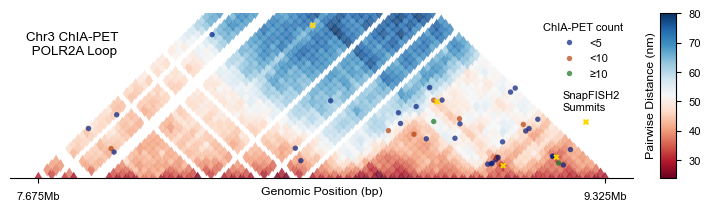

In [21]:
sub_df = chiapet_sub_df(chr_id, adata.var, polr2a_path, cut_lo, cut_hi)

fig = plt.figure(figsize=(7, 2))
ax, cbar = sf.pl.triangle_heatmap(med_dist, adata.var, cut_hi=cut_hi, fig=fig)[1:]
cbar.set_label("Pairwise Distance (nm)", labelpad=-40)
df = sf.pl.rotate_df(sub_df)
df["cls"] = pd.cut(df["count"], bins=[0, 5, 10, 1e8], 
                   labels=["<5", "<10", "≥10"])
sns.scatterplot(df, x="x_rot", y="y_rot", marker="o", hue="cls", ax=ax, 
                palette="dark", linewidth=0, s=15, alpha=0.7)

sub_df = res_sf2[res_sf2["c1"]==chr_id]
sub_df = sub_df[sub_df["final"]]
df = sf.pl.rotate_df(pd.DataFrame({
    "x": sub_df[["s1", "e1"]].mean(axis=1), 
    "y": sub_df[["s2", "e2"]].mean(axis=1)
}))
df["h"] = " "
sns.scatterplot(df, x="x_rot", y="y_rot", hue="h", marker="X", ax=ax, 
                palette={" ": "gold"}, linewidth=0, s=20)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[-1:], labels[-1:], bbox_to_anchor=(.88, 0.28),
                   title="SnapFISH2\nSummits", title_fontsize=sf.settings.fontsize*.8)
ax.legend(handles[-4:-1], labels[-4:-1], loc="upper right", 
          title="ChIA-PET count", title_fontsize=sf.settings.fontsize*.8)
plt.gca().add_artist(legend)
ax.set_title(f"{chr_id.title()} ChIA-PET\n POLR2A Loop", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "s5c_polr2a_chr3.pdf"), bbox_inches="tight")

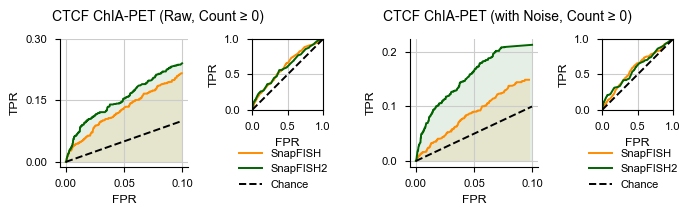

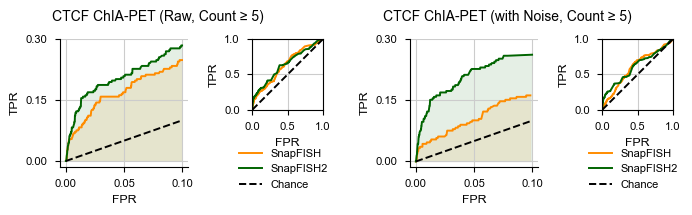

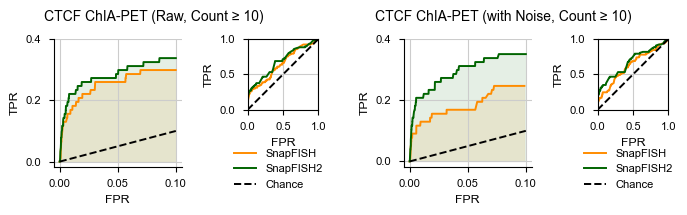

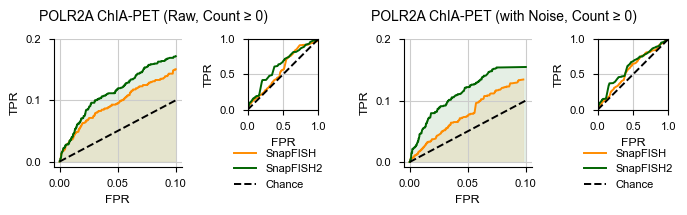

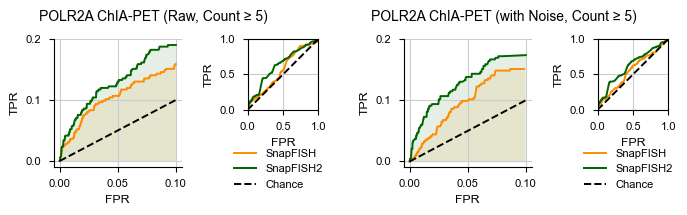

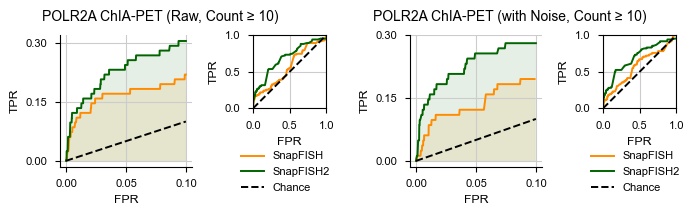

In [22]:
from utils.utils import create_roc_df
from utils.lines import roc_curve_pl
for target, v1 in pet_paths.items():
    for k, v in v1.items():
        fig = plt.figure(figsize=(7, 2))
        sfig = fig.subfigures(1, 2)
        roc_df = create_roc_df(v, res_sf1, res_sf2)
        roc_curve_pl(roc_df, sfig[0], f"{target} ChIA-PET (Raw, Count ≥ {k})")
        roc_df = create_roc_df(v, res_sf1_noised, res_sf2_noised)
        roc_curve_pl(roc_df, sfig[1], f"{target} ChIA-PET (with Noise, Count ≥ {k})")
        fig.savefig(os.path.join(out_dire, f"2c_roc_{target}_{k}.pdf"), bbox_inches="tight")

## FitHiC2 and HiCCUPS

Benchmark data: mESC from Bonev et al

FitHiC2: 4DNFI4OUMWZ8 (G0G1 phase cells and mESCs)

In [23]:
fithic2_path = os.path.join(out_dire, "fithic2.bedpe")
fit_fname = "../data/bonev_cell_2017/output/" \
    + "merged.spline_pass1.res10000.significances.fdr.0.01.bedpe"
fdf = pd.read_csv(fit_fname, sep="\t", header=None)
fdf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "CC", "pval", "fdr"]
loop_len = fdf["s2"] - fdf["s1"]
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
fdf = fdf[(loop_len >= 1e5)&(loop_len <= 1e6)]
if not os.path.exists(fithic2_path):
    fithic2 = []
    for chr_id in loader.chr_ids:
        d1df = loader.create_adata(chr_id).var
        d1df["Chrom"] = chr_id
        cover_df = sf.tl.all_possible_pairs(d1df)
        df = sf.tl.loop_overlap(fdf[fdf["c1"]==chr_id], cover_df)
        fithic2.append(df[df["overlapped"]==3])
    fithic2 = pd.concat(fithic2, ignore_index=True)[cols]
    fithic2.to_csv(fithic2_path, sep="\t", index=False, header=False)
else:
    fithic2 = pd.read_csv(fithic2_path, sep="\t", header=None)
    fithic2.columns = cols

In [24]:
# Why setting the second cutoff to 1e-5
fdf.pval.quantile([0, .25, .5, .75, 1])

0.00    3.447658e-136
0.25     4.749893e-14
0.50     1.715487e-08
0.75     1.745302e-06
1.00     3.044403e-05
Name: pval, dtype: float64

In [238]:
hicexpl_path = os.path.join(out_dire, "hicexpl.bedpe")
exp_fname = "../data/bonev_cell_2017/hicexplorer.bedgraph"
edf = pd.read_csv(exp_fname, sep="\t", header=None)
edf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "pval"]
edf["c1"] = "chr" + edf["c1"].astype(str)
edf["c2"] = "chr" + edf["c2"].astype(str)
loop_len = edf["s2"] - edf["s1"]
assert (loop_len > 0).all()
edf = edf[(loop_len >= 1e5)&(loop_len <= 1e6)]
if not os.path.exists(hicexpl_path):
    hicexpl = []
    for chr_id in loader.chr_ids:
        d1df = loader.create_adata(chr_id).var
        d1df["Chrom"] = chr_id
        cover_df = sf.tl.all_possible_pairs(d1df)
        df = sf.tl.loop_overlap(edf[edf["c1"]==chr_id], cover_df)
        hicexpl.append(df[df["overlapped"]==3])
    hicexpl = pd.concat(hicexpl, ignore_index=True)
    hicexpl.to_csv(hicexpl_path, sep="\t", index=False, header=False)
else:
    hicexpl = pd.read_csv(hicexpl_path, sep="\t")
    hicexpl.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "overlapped"]

In [26]:
edf.pval.quantile([0, .25, .5, .75, 1])

0.00    1.504470e-48
0.25    4.813606e-22
0.50    6.169759e-16
0.75    9.189036e-11
1.00    4.935939e-02
Name: pval, dtype: float64

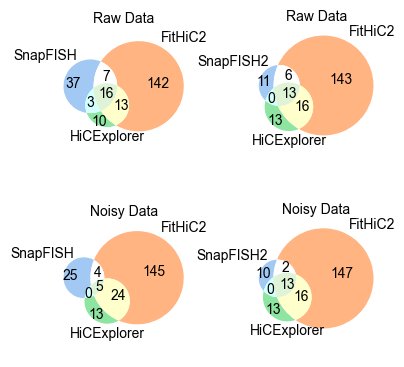

In [27]:
from utils.maps import venn3_loops
fig, axes = plt.subplots(2, 2, figsize=(4, 4))
fig.tight_layout()
venn = venn3_loops(hicexpl, fithic2, res_sf1[res_sf1["final"]], 
                   "SnapFISH", "Raw Data", ax=axes[0][0])
venn = venn3_loops(hicexpl, fithic2, res_sf2[res_sf2["final"]], 
                   "SnapFISH2", "Raw Data", ax=axes[0][1])
venn = venn3_loops(hicexpl, fithic2, res_sf1_noised[res_sf1_noised["final"]], 
                   "SnapFISH", "Noisy Data", ax=axes[1][0])
venn = venn3_loops(hicexpl, fithic2, res_sf2_noised[res_sf2_noised["final"]], 
                   "SnapFISH2", "Noisy Data", ax=axes[1][1])
fig.savefig(os.path.join(out_dire, "2d_loop_overlap.pdf"), bbox_inches="tight")

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


0.38461538461538464

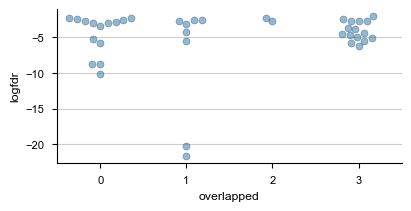

In [28]:
res_df = res_sf1[res_sf1["summit"]].copy()
res_df = res_df[res_df["fdr"] < 0.01]
res_df["overlapped"] = sf.tl.loop_overlap(res_df, fithic2)["overlapped"]
res_df["logfdr"] = np.log10(res_df["fdr"])
fig, ax = plt.subplots(figsize=(4, 2))
sns.swarmplot(res_df, x="overlapped", y="logfdr", linewidth=0.5, alpha=.5)
len(res_df[res_df["overlapped"]==3])/len(res_df)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


0.5416666666666666

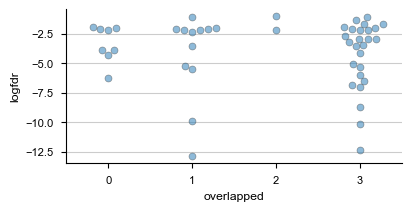

In [29]:
res_df = res_sf2[res_sf2["summit"]].copy()
res_df = res_df[res_df["pval"] < 1e-4]
res_df["overlapped"] = sf.tl.loop_overlap(
    res_df, fithic2, offset=25e3    
)["overlapped"]
res_df["logfdr"] = np.log10(res_df["fdr"])
fig, ax = plt.subplots(figsize=(4, 2))
sns.swarmplot(res_df, x="overlapped", y="logfdr", linewidth=0.5, alpha=.5)
len(res_df[res_df["overlapped"]==3])/len(res_df)

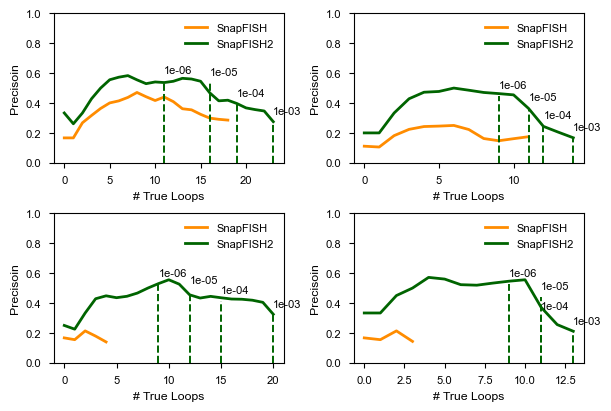

In [396]:
from utils.lines import precision_recall_loop
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
precision_recall_loop(res_sf1, res_sf2, fdf, axes[0][0])
precision_recall_loop(res_sf1, res_sf2, edf, axes[0][1])
precision_recall_loop(res_sf1_noised, res_sf2_noised, fdf, axes[1][0])
precision_recall_loop(res_sf1_noised, res_sf2_noised, edf, axes[1][1])
fig.savefig(os.path.join(out_dire, "s6_precision_recall.pdf"), bbox_inches="tight")

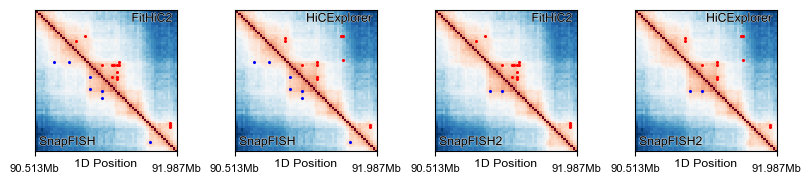

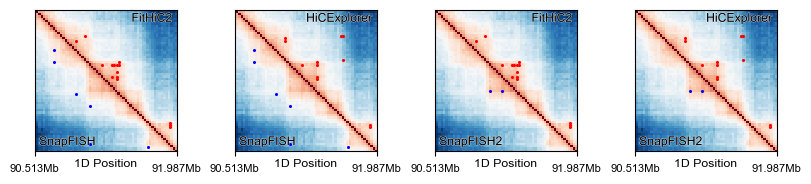

In [397]:
from utils.maps import loop_map
fig = loop_map(loader, "chr16", fdf, edf, res_sf1, res_sf2)
fig.savefig(os.path.join(out_dire, "s6_loop_map1.pdf"), bbox_inches="tight")
fig = loop_map(loader, "chr16", fdf, edf, res_sf1_noised, res_sf2_noised)
fig.savefig(os.path.join(out_dire, "s6_loop_map2.pdf"), bbox_inches="tight")

`python -m pip install igv-notebook`

In [135]:
res_sf1[res_sf1["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s1_raw.bedpe"), index=False, sep="\t"
)
res_sf1_noised[res_sf1_noised["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s1_noi.bedpe"), index=False, sep="\t"
)
res_sf2[res_sf2["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s2_raw.bedpe"), index=False, sep="\t"
)
res_sf2_noised[res_sf2_noised["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s2_noi.bedpe"), index=False, sep="\t"
)

In [136]:
c1_rgb = tuple(int(255 * x) for x in c1)
c2_rgb = tuple(int(255 * x) for x in c2)

In [402]:
import igv_notebook
igv_notebook.init()
chr_id = "chr6"
d1df = loader.create_adata(chr_id).var
igv_browser= igv_notebook.Browser({
    "genome": "mm10", 
    "locus":  f"{chr_id}:{d1df.Chrom_Start.min() + 1e5}-{d1df.Chrom_End.max() - 1e5}",
    "tracks": [{
        "name": "HiCExplorer", "url": hicexpl_path, 
        "format": "bedpe", "height": 50, "color": "red"
    }, {"name": "SnapFISH (Raw)",
        "url": os.path.join(out_dire, "final_summit_s1_raw.bedpe"),
        "format": "bedpe", "height": 50, "color": f"rgb{c1_rgb.__repr__()}"
    }, {"name": "SnapFISH2 (Raw)",
        "url": os.path.join(out_dire, "final_summit_s2_raw.bedpe"),
        "format": "bedpe", "height": 50, "color": f"rgb{c2_rgb.__repr__()}"
    }, {"name": "SnapFISH (with Noise)",
        "url": os.path.join(out_dire, "final_summit_s1_noi.bedpe"),
        "format": "bedpe", "height": 50, "color": f"rgb{c1_rgb.__repr__()}"
    }, {"name": "SnapFISH2 (with Noise)",
        "url": os.path.join(out_dire, "final_summit_s2_noi.bedpe"),
        "format": "bedpe", "height": 50, "color": f"rgb{c2_rgb.__repr__()}"
    }, {"name": "ChIP-seq CTCF",
        "url": dtree["chipseq_mesc", "CTCF", "bigWig"],
        "format": "bigwig", "height": 50, "color": "darkorange"
    }]
})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Sox2 Promotor Data

In [427]:
loader_sox2 = sf.pp.FOF_CT_Loader({
    "between": dtree["huang_ng_2021","between"],
    "between_rna": dtree["huang_ng_2021","between_rna"]
})
adata_sox2 = loader_sox2.create_adata("chr3")
allele = adata_sox2.obs.index.str.replace(r"^.*_", "", regex=True)
adata_sox2.obs["allele"] = allele

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


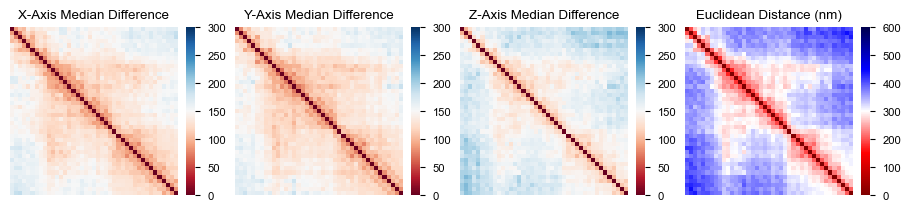

In [443]:
from utils.maps import dist_diff_heatmaps
sox2_cast = adata_sox2[adata_sox2.obs["allele"]=="CAST"].copy()
fig, axes = plt.subplots(1, 4, figsize=(9, 2))
dist_diff_heatmaps(axes, sox2_cast, 300, 600)

In [446]:
dtree["takei_nature_2021", "25Kb", "rep1"]

'../data/takei_nature_2021/4DNFIHF3JCBY.csv'